In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append("clustering")
from utils import get_data_dir

# Abstract-based classification

In [3]:
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def extract_and_process_large_json(input_file, train_file, test_file, 
                                   target_Scopus_label="Biochemistry, Genetics and Molecular Biology", 
                                   target_cluster_label=22, limit=50000, test_size=0.2):
    """
    从大 JSON 文件中提取目标数据，按指定比例划分 Scopus_label 和 cluster_label。
    
    Args:
        input_file (str): 输入 JSON 文件路径。
        train_file (str): 输出训练集 JSON 文件路径。
        test_file (str): 输出测试集 JSON 文件路径。
        target_scopus_label (str): 目标 Scopus_label 标签。
        target_cluster_label (int): 目标 cluster_label 标签。
        limit (int): 总样本数量。
        test_size (float): 测试集比例。

    Returns:
        dict: Scopus_label 的编码映射。
    """
    # 数据容器
    scopus_target = []
    scopus_non_target = []
    cluster_target = []
    cluster_non_target = []

    # 逐行读取大文件
    with open(input_file, 'r', encoding='utf-8') as infile:
        for line in infile:
            try:
                # 去掉多余逗号并解析 JSON
                record = json.loads(line.strip(",\n"))
                scopus_label = record.get("Scopus_label", "")
                cluster_label = record.get("cluster_label", None)

                # 分类数据
                if scopus_label == target_Scopus_label and len(scopus_target) < limit // 2:
                    scopus_target.append(record)
                elif scopus_label != target_Scopus_label and len(scopus_non_target) < limit // 2:
                    scopus_non_target.append(record)
                
                if cluster_label == target_cluster_label and len(cluster_target) < limit // 2:
                    cluster_target.append(record)
                elif cluster_label != target_cluster_label and len(cluster_non_target) < limit // 2:
                    cluster_non_target.append(record)
                
                # 如果四个类别都达到限制，停止读取
                if (len(scopus_target) >= limit // 2 and len(scopus_non_target) >= limit // 2 and
                    len(cluster_target) >= limit // 2 and len(cluster_non_target) >= limit // 2):
                    break
            except json.JSONDecodeError:
                continue  # 跳过解析失败的行

    print(f"已提取 {len(scopus_target)} 篇 {target_Scopus_label} 记录和 {len(scopus_non_target)} 篇非 {target_Scopus_label} 记录")
    print(f"已提取 {len(cluster_target)} 篇目标 cluster_label 记录和 {len(cluster_non_target)} 篇非目标 cluster_label 记录")

    # 合并数据
    scopus_data = scopus_target + scopus_non_target
    cluster_data = cluster_target + cluster_non_target
    all_data = scopus_data + cluster_data

    # 对 Scopus_label 和 cluster_label 进行编码
    labels = [record["Scopus_label"] for record in all_data]
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)
    for i, record in enumerate(all_data):
        record["Scopus_label"] = int(encoded_labels[i])
    
    label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

    # 分割数据为训练集和测试集
    train_data, test_data = train_test_split(all_data, test_size=test_size, random_state=42)

    # 保存到 JSON 文件
    with open(train_file, 'w', encoding='utf-8') as trainfile:
        json.dump(train_data, trainfile, indent=2)
    with open(test_file, 'w', encoding='utf-8') as testfile:
        json.dump(test_data, testfile, indent=2)
    
    print(f"训练数据保存到 {train_file}，测试数据保存到 {test_file}")
    return label_mapping


/home/lyuzhuoqi/miniconda3/envs/p2v/lib/python3.11/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
target_Scopus_label = "Biochemistry, Genetics and Molecular Biology"
target_cluster_label = 22

# 使用示例
Scopus_label_map = extract_and_process_large_json(
    input_file=os.path.join(get_data_dir(),"2010s","dataset.json"),
    train_file=os.path.join(get_data_dir(), "2010s","train.json"),
    test_file=os.path.join(get_data_dir(), "2010s","test.json"),
    target_Scopus_label=target_Scopus_label,
    target_cluster_label=target_cluster_label,
    limit=50000,
    test_size=0.2
)

data_dir:  /home/lyuzhuoqi/projects/clustering/data
data_dir:  /home/lyuzhuoqi/projects/clustering/data
data_dir:  /home/lyuzhuoqi/projects/clustering/data


已提取 25000 篇 Biochemistry, Genetics and Molecular Biology 记录和 25000 篇非 Biochemistry, Genetics and Molecular Biology 记录
已提取 25000 篇目标 cluster_label 记录和 25000 篇非目标 cluster_label 记录
训练数据保存到 /home/lyuzhuoqi/projects/clustering/data/2010s/train.json，测试数据保存到 /home/lyuzhuoqi/projects/clustering/data/2010s/test.json


In [5]:
Scopus_label_map['Biochemistry, Genetics and Molecular Biology']

2

In [6]:
import json

def load_data(train_file, test_file):
    """
    加载训练集和测试集数据。
    
    Args:
        train_file (str): 训练集文件路径。
        test_file (str): 测试集文件路径。
    
    Returns:
        list: 训练集数据。
        list: 测试集数据。
    """
    with open(train_file, 'r', encoding='utf-8') as f:
        train_data = json.load(f)
    with open(test_file, 'r', encoding='utf-8') as f:
        test_data = json.load(f)
    return train_data, test_data

# 加载数据
train_file = os.path.join(get_data_dir(),"2010s","train.json")
test_file = os.path.join(get_data_dir(),"2010s","test.json")
train_data, test_data = load_data(train_file, test_file)

data_dir:  /home/lyuzhuoqi/projects/clustering/data
data_dir:  /home/lyuzhuoqi/projects/clustering/data


In [7]:
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# 自定义词映射
word_mapping = {'mechanics': 'mechanic',
                'mechanical': 'mechanic',
                'electrical': 'electric',
                'electronics': 'electric',
                'financial': 'finance',
                'political': 'politics',
                'historical': 'history',
                'computer': 'computing',
                'intelligent': 'intelligence',
                'agricultural': 'agriculture',
                'educational': 'education',
                'dental': 'dentistry',
                'archaeological': 'archaeology',
                'mathematical': 'mathematics',
                'mathematica': 'mathematics',
                'matematico': 'mathematics',
                'mathematicae': 'mathematics',
                'economic': 'economics',
                'chemical': 'chemistry',
                'geophysical': 'geophysics',
                'botanical': 'botany',
                'physical': 'physics',
                'entomological': 'entomology', 
                'entomologist': 'entomology',
                'biological': 'biology',
                'geographical': 'geography',
                'geological': 'geology',
                'geographer': 'geography',
                'cells': 'cell',
                'policy': 'politics',
                'psychological': 'psychology',
                'linguistical': 'linguistics',
                'linguistica': 'linguistics',
                'medical': 'medicine',
}

paper_df = pd.concat([pd.DataFrame(train_data), pd.DataFrame(test_data)])

# 定义预处理函数，进行自定义词映射
def preprocess_text(text):
    words = text.lower().split()  # 将文本小写并按空格分词
    mapped_words = [word_mapping[word] if word in word_mapping else word for word in words]
    filtered_words = [word for word in mapped_words]
    return ' '.join(filtered_words)

# 按 cluster_label 分组，将 OriginalVenue 文本合并为一个文档，并进行预处理
cluster_docs = (
    paper_df.groupby('cluster_label').parallel_apply(lambda x: preprocess_text(' '.join(x.abstract))).tolist()
)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [8]:
# 自定义停用词
custom_stop_words = ['results', 'model', 'based', 'data', 'proposed', 'study', 'paper', 'results', 
                     'system', 'patients', 'using', 'method', 'health', 'two', 'article', 'la', 'que', 'en',
                     'el', 'et', 'un', 'one', 'also', 'high', 'properties', 'methods', 'among', 'new',
                     'sp', 'use', 'group', 'used', 'process', 'kg', 'abstract', 'different', 'time',
                     'treatment', 'analysis', 'different', 'performance', 'le', 'los', 'se', 'les',
                     'mm', 'may', 'de', 'del', 'des', 'nov', 'found', 'research', 'showed', 'las',
                     'development', 'years', 'da', 'studies', 'first', 'findings', 'di', 'however', 'three',
                     'associated', 'relationship', 'design', 'em', 'approach', 'risk', 'patient', 'care',
                     '95', 'age', 'ci', 'compared', '10', 'background', 'conclusions', 'significant',
                     'higher', 'vs', 'mortality', 'therapy', 'increased', 'significantly', '19', 'children',
                     'find', 'show', 'problem', 'mathrm', 'included', 'mean', 'systems', '12', 'effects',
                     'participants', 'related', 'cases', 'disease', 'levels', 'outcomes', 'non', 'total',
                     'factors', 'conclusion', 'nm', 'ra', 'year', 'dr'
                     ]

# 计算 TF-IDF
top_words_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english')+custom_stop_words)
tfidf_matrix = top_words_vectorizer.fit_transform(cluster_docs)

In [9]:
top_n = 10  # 每个聚类提取前 n 个关键词
# 获取每个聚类中最重要的关键词
top_words = {}
feature_names = top_words_vectorizer.get_feature_names_out()

# 确保 cluster_label 的顺序与 cluster_docs 一致
cluster_labels = sorted(paper_df['cluster_label'].unique())

for j, cluster_label in enumerate(cluster_labels):
    tfidf_scores = tfidf_matrix[j].toarray().flatten()
    top_indices = tfidf_scores.argsort()[-top_n:][::-1]  # 获取前 n 个关键词的索引
    top_words[cluster_label] = [feature_names[idx] for idx in top_indices]

top_words

{0: ['energy',
  'temperature',
  'heat',
  'flow',
  'surface',
  'effect',
  'thermal',
  'water',
  'experimental',
  'strength'],
 1: ['algorithm',
  'learning',
  'information',
  'fuzzy',
  'image',
  'network',
  'real',
  'models',
  'algorithms',
  'propose'],
 2: ['social',
  'corporate',
  'business',
  'management',
  'firms',
  'work',
  'purpose',
  'tourism',
  'brand',
  'csr'],
 3: ['power',
  'control',
  'algorithm',
  'network',
  'voltage',
  'antenna',
  'energy',
  'frequency',
  'sensor',
  'scheme'],
 4: ['dogs',
  'cows',
  'animals',
  'cattle',
  'control',
  'infection',
  'cell',
  'days',
  'horses',
  'genes'],
 5: ['plant',
  'soil',
  'acid',
  'species',
  'plants',
  'protein',
  'gene',
  'activity',
  'mg',
  'production'],
 6: ['archaeology',
  'parentesco',
  'heritage',
  'pupuk',
  'kandang',
  'anamensis',
  'eta',
  '14c',
  'δ13',
  'microwear'],
 7: ['dentistry',
  'bone',
  'periodontal',
  'oral',
  'implants',
  'implant',
  'clinical',


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

def preprocess_data(data, label_field, target_value=None):
    """
    对数据进行预处理，提取文本特征和标签。
    
    Args:
        data (list): 数据列表。
        label_field (str): 目标标签字段名（如 Scopus_label 或 cluster_label）。
        target_value (str or int): 目标分类的值（如 Medicine 或 1）。
    
    Returns:
        list: 文本数据列表。
        list: 标签数据列表。
    """
    texts = [item["abstract"] for item in data]
    if target_value is not None:
        labels = [1 if item[label_field] == target_value else 0 for item in data]
    else:
        labels = [item[label_field] for item in data]
    return texts, labels

def train_and_evaluate_with_tfidf(vectorizer, train_texts, train_labels, test_texts, test_labels):
    """
    使用预训练的 TF-IDF 进行向量化并训练 Random Forest 模型。
    
    Args:
        vectorizer (TfidfVectorizer): 已拟合的 TF-IDF 向量化器。
        train_texts (list): 训练文本数据。
        train_labels (list): 训练标签数据。
        test_texts (list): 测试文本数据。
        test_labels (list): 测试标签数据。
    """
    # 使用已拟合的 TF-IDF 进行向量化
    X_train = vectorizer.transform(train_texts)
    X_test = vectorizer.transform(test_texts)

    # 随机森林分类器
    classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    classifier.fit(X_train, train_labels)

    # 预测与评估
    predictions = classifier.predict(X_test)
    print("Classification Report:")
    print(classification_report(test_labels, predictions))
    print("Test accuracy:", accuracy_score(test_labels, predictions))

    return predictions

In [ ]:
# Baseline task: 使用 Scopus_label 进行分类
print(f"\nBaseline task: Binary classification based on Scopus_label ({target_Scopus_label} V.S. others)")
train_texts, train_labels = preprocess_data(train_data, label_field="Scopus_label", target_value=Scopus_label_map[target_Scopus_label])
test_texts, test_labels = preprocess_data(test_data, label_field="Scopus_label", target_value=Scopus_label_map['Biochemistry, Genetics and Molecular Biology'])

# 拟合 TF-IDF（仅在训练数据上）
print("Fitting TF-IDF vectorizer...")
vectorizer = TfidfVectorizer(max_features=10000, stop_words=stopwords.words('english'))
vectorizer.fit(train_texts)


Baseline task: Binary classification based on Scopus_label (Biochemistry, Genetics and Molecular Biology V.S. others)
Fitting TF-IDF vectorizer...


Training and evaluating Random Forest classifier...
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91     13218
           1       0.83      0.81      0.82      6782

    accuracy                           0.88     20000
   macro avg       0.87      0.87      0.87     20000
weighted avg       0.88      0.88      0.88     20000

Test accuracy: 0.88225


Training and evaluating Random Forest classifier...


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91     13218
           1       0.83      0.81      0.82      6782

    accuracy                           0.88     20000
   macro avg       0.87      0.87      0.87     20000
weighted avg       0.88      0.88      0.88     20000

Test accuracy: 0.88225


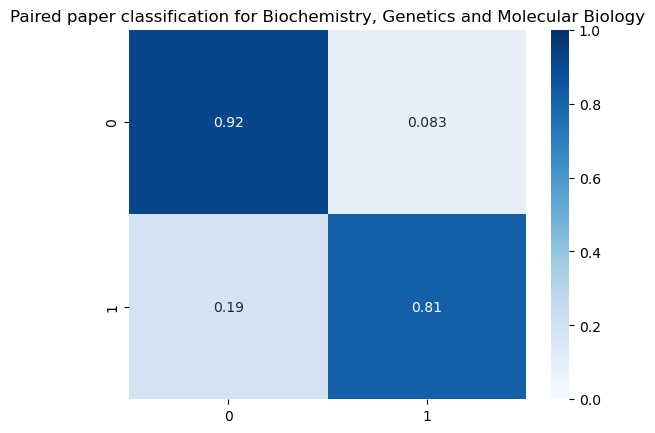

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

print("Training and evaluating Random Forest classifier...")
predictions = train_and_evaluate_with_tfidf(vectorizer, train_texts, train_labels, test_texts, test_labels)

cm = confusion_matrix(test_labels, predictions, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues', vmin=0, vmax=1)
plt.title(f"Paired paper classification for {target_Scopus_label}")
plt.show()

In [20]:
from collections import Counter

target_cluster_label = 22

# 任务 2: 使用 cluster_label 进行分类 
print(f"\nBaseline task: Binary classification based on cluster_label (Cluster No.:{target_cluster_label} V.S. others)")
print("Top words:", top_words[target_cluster_label])
train_texts, train_labels = preprocess_data(train_data, label_field="cluster_label", target_value=target_cluster_label)
test_texts, test_labels = preprocess_data(test_data, label_field="cluster_label", target_value=target_cluster_label)

# 拟合 TF-IDF（仅在训练数据上）
print("Fitting TF-IDF vectorizer...")
vectorizer = TfidfVectorizer(max_features=10000, stop_words=stopwords.words('english'))
vectorizer.fit(train_texts)


Baseline task: Binary classification based on cluster_label (Cluster No.:22 V.S. others)
Top words: ['cell', 'cancer', 'protein', 'expression', 'tumor', 'cells', 'gene', 'genes', 'breast', 'induced']
Fitting TF-IDF vectorizer...


TfidfVectorizer(max_features=10000,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

Training and evaluating Random Forest classifier...


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     10304
           1       0.92      0.90      0.91      9696

    accuracy                           0.92     20000
   macro avg       0.92      0.91      0.91     20000
weighted avg       0.92      0.92      0.91     20000

Test accuracy: 0.915


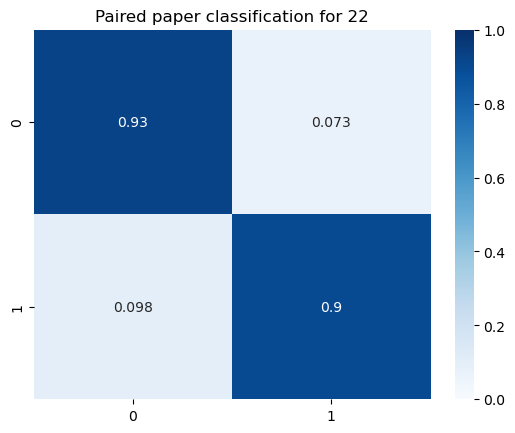

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

print("Training and evaluating Random Forest classifier...")
predictions = train_and_evaluate_with_tfidf(vectorizer, train_texts, train_labels, test_texts, test_labels)

cm = confusion_matrix(test_labels, predictions, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues', vmin=0, vmax=1)
plt.title(f"Paired paper classification for {target_cluster_label}")
plt.show()

# Journal-title-based classification

In [3]:
import os
import pandas as pd

cluster_df = pd.read_parquet(os.path.join(get_data_dir(), "2010s", "cluster_df.parquet"))
cluster_df

data_dir:  /home/lyuzhuoqi/projects/clustering/data


,Scopus_label,movMF_label,movMF_distance,x_val,y_val,kmeans_label,kmeans_distance,skm_label,skm_distance
VID,,,,,,,,,
202381698,Multidisciplinary,22,0.445886,-67.928200,15.572327,17,0.628846,20,0.444711
137773608,Multidisciplinary,22,0.590942,-68.405334,-55.633186,17,0.735654,20,0.559494
125754415,Multidisciplinary,22,0.574571,-68.448853,-55.613579,17,0.705024,20,0.550081
3880285,Multidisciplinary,23,0.618842,-68.407288,-55.634430,8,0.724859,17,0.610582
111155417,Chemistry,23,0.220853,-54.506985,-61.217068,11,0.495787,12,0.198758
...,...,...,...,...,...,...,...,...,...
2764485818,Medicine,21,0.268070,-28.969574,34.819569,18,0.542531,14,0.251015
83454320,Arts and Humanities,25,0.034777,78.609909,31.736822,13,0.251599,3,0.056642
16507453,Arts and Humanities,6,0.113656,89.206772,17.625090,13,0.307089,3,0.128660


In [4]:
venue_df = pd.read_parquet(os.path.join(get_data_dir(),"MAG_venue.parquet"))
venue_df

data_dir:  /home/lyuzhuoqi/projects/clustering/data


,VenueType,OriginalVenue
VID,,
3006142753,Journal,Proceedings of The Royal Society of London
194691280,Journal,Annalen der Physik
177993953,Journal,Journal of Literacy Research
168309380,Journal,Philosophical Magazine
93133213,Journal,Western Journal of Communication
...,...,...
938070683,Journal,Corporate Philanthropy Report
946020915,Journal,Africa Research Bulletin
6224198,Journal,Loisir & Societe-society and Leisure


In [7]:
cluster_df = pd.merge(cluster_df, venue_df['OriginalVenue'], left_index=True, right_index=True)
cluster_df

,Scopus_label,movMF_label,movMF_distance,x_val,y_val,kmeans_label,kmeans_distance,skm_label,skm_distance,OriginalVenue
VID,,,,,,,,,,
202381698,Multidisciplinary,22,0.445886,-67.928200,15.572327,17,0.628846,20,0.444711,PLOS ONE
137773608,Multidisciplinary,22,0.590942,-68.405334,-55.633186,17,0.735654,20,0.559494,Nature
125754415,Multidisciplinary,22,0.574571,-68.448853,-55.613579,17,0.705024,20,0.550081,Proceedings of the National Academy of Science...
3880285,Multidisciplinary,23,0.618842,-68.407288,-55.634430,8,0.724859,17,0.610582,Science
111155417,Chemistry,23,0.220853,-54.506985,-61.217068,11,0.495787,12,0.198758,Journal of the American Chemical Society
...,...,...,...,...,...,...,...,...,...,...
2764485818,Medicine,21,0.268070,-28.969574,34.819569,18,0.542531,14,0.251015,The internet journal of the third world medicine
83454320,Arts and Humanities,25,0.034777,78.609909,31.736822,13,0.251599,3,0.056642,Publications of The English Goethe Society
16507453,Arts and Humanities,6,0.113656,89.206772,17.625090,13,0.307089,3,0.128660,Peritia


In [39]:
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

method = 'movMF'
# 自定义词映射
word_mapping = {'mechanics': 'mechanic',
                'mechanical': 'mechanic',
                'electrical': 'electric',
                'electronics': 'electric',
                'financial': 'finance',
                'political': 'politics',
                'historical': 'history',
                'computer': 'computing',
                'intelligent': 'intelligence',
                'agricultural': 'agriculture',
                'educational': 'education',
                'dental': 'dentistry',
                'archaeological': 'archaeology',
                'mathematical': 'mathematics',
                'mathematica': 'mathematics',
                'matematico': 'mathematics',
                'mathematicae': 'mathematics',
                'economic': 'economics',
                'chemical': 'chemistry',
                'geophysical': 'geophysics',
                'botanical': 'botany',
                'physical': 'physics',
                'entomological': 'entomology', 
                'entomologist': 'entomology',
                'biological': 'biology',
                'geographical': 'geography',
                'geological': 'geology',
                'geographer': 'geography',
                'cells': 'cell',
                'policy': 'politics',
                'psychological': 'psychology',
                'linguistical': 'linguistics',
                'linguistica': 'linguistics',
                'medical': 'medicine',
}
# 读取数据
cluster_df = pd.read_parquet(os.path.join(get_data_dir(), "2010s", "cluster_df.parquet"))
cluster_df = cluster_df.merge(pd.read_parquet(os.path.join(get_data_dir(), "MAG_venue.parquet")), left_index=True, right_index=True)

# 定义预处理函数，进行自定义词映射
def preprocess_text(text):
    words = text.lower().split()  # 将文本小写并按空格分词
    mapped_words = [word_mapping[word] if word in word_mapping else word for word in words]
    filtered_words = [word for word in mapped_words]
    return ' '.join(filtered_words)

# 按 cluster_label 分组，将 OriginalVenue 文本合并为一个文档，并进行预处理
cluster_docs = (
    cluster_df.groupby(f'{method}_label').parallel_apply(lambda x: preprocess_text(' '.join(x.OriginalVenue))).tolist()
)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
data_dir:  /home/lyuzhuoqi/projects/clustering/data
data_dir:  /home/lyuzhuoqi/projects/clustering/data


In [68]:
# 自定义停用词
# 自定义停用词
custom_stop_words = ['the', 'and', 'of', 'to', 'in', 'a', 'for', 'is', 'on', 'that', 'de', 'di', 'des', 'del',
                     'medizinische', 'clinica', 'wochenschrift', 'rendiconti',
                     'journal', 'letters', 'studies', 'international', 'transactions', 'acta', 
                     'revista', 'research', 'review', 'sciences', 'science', 'chinese', 'theory', 'applied']

# 计算 TF-IDF
top_words_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english')+custom_stop_words)
tfidf_matrix = top_words_vectorizer.fit_transform(cluster_docs)

In [69]:
top_n = 5  # 每个聚类提取前 n 个关键词
# 获取每个聚类中最重要的关键词
top_words = {}
feature_names = top_words_vectorizer.get_feature_names_out()

# 确保 cluster_label 的顺序与 cluster_docs 一致
cluster_labels = sorted(cluster_df[f'{method}_label'].unique())

for j, cluster_label in enumerate(cluster_labels):
    tfidf_scores = tfidf_matrix[j].toarray().flatten()
    top_indices = tfidf_scores.argsort()[-top_n:][::-1]  # 获取前 n 个关键词的索引
    top_words[cluster_label] = [feature_names[idx] for idx in top_indices]

top_words

{0: ['engineering', 'mechanic', 'technology', 'materials', 'energy'],
 1: ['intelligence', 'computing', 'systems', 'information', 'artificial'],
 2: ['management', 'business', 'marketing', 'accounting', 'entrepreneurship'],
 3: ['electric', 'ieee', 'systems', 'engineering', 'power'],
 4: ['veterinary', 'animal', 'veterinaria', 'medicine', 'poultry'],
 5: ['plant', 'food', 'agriculture', 'biotechnology', 'biology'],
 6: ['archaeology', 'history', 'medieval', 'anthropology', 'heritage'],
 7: ['dentistry', 'oral', 'maxillofacial', 'orthodontics', 'surgery'],
 8: ['neurology', 'neuroscience', 'clinical', 'ophthalmology', 'brain'],
 9: ['laser', 'sinica', 'engineering', 'optics', 'geo'],
 10: ['sports', 'medicine', 'rehabilitation', 'orthopaedics', 'surgery'],
 11: ['education', 'learning', 'teaching', 'higher', 'language'],
 12: ['psychology', 'health', 'nursing', 'psychiatry', 'social'],
 13: ['ecology', 'entomology', 'biology', 'zoology', 'marine'],
 14: ['computing', 'acm', 'systems', '

In [43]:
target_cluster_label = 24
target_Scopus_label = "Arts and Humanities"

print(len(cluster_df[(cluster_df['movMF_label'] == target_cluster_label)&(cluster_df['Scopus_label'] == target_Scopus_label)]))
print(len(cluster_df[(cluster_df['movMF_label'] == target_cluster_label)&(cluster_df['Scopus_label'] != target_Scopus_label)]))
print(len(cluster_df[(cluster_df['movMF_label'] != target_cluster_label)&(cluster_df['Scopus_label'] == target_Scopus_label)]))
print(len(cluster_df[(cluster_df['movMF_label'] != target_cluster_label)&(cluster_df['Scopus_label'] != target_Scopus_label)]))

427
587
1134
17890


In [53]:
dataset_df = pd.concat([cluster_df[(cluster_df['movMF_label'] == 24)&(cluster_df['Scopus_label'] == 'Arts and Humanities')].sample(400), 
           cluster_df[(cluster_df['movMF_label'] == 24)&(cluster_df['Scopus_label'] != 'Arts and Humanities')].sample(400),
           cluster_df[(cluster_df['movMF_label'] != 24)&(cluster_df['Scopus_label'] == 'Arts and Humanities')].sample(400), 
           cluster_df[(cluster_df['movMF_label'] != 24)&(cluster_df['Scopus_label'] != 'Arts and Humanities')].sample(400)])
dataset_df['target_Scopus_label'] = (dataset_df['Scopus_label'] == target_Scopus_label).astype(int)
dataset_df['target_cluster_label'] = (dataset_df[f'{method}_label'] == target_cluster_label).astype(int)

In [54]:
dataset_df

,Scopus_label,movMF_label,movMF_distance,x_val,y_val,kmeans_label,kmeans_distance,skm_label,skm_distance,VenueType,OriginalVenue,target_Scopus_label,target_cluster_label
VID,,,,,,,,,,,,,
111105241,Arts and Humanities,24,0.269105,88.761391,26.528320,23,0.422247,3,0.248389,Journal,Popular Music History,1,1
2736043517,Arts and Humanities,24,0.310765,86.480515,35.140072,13,0.461256,3,0.306215,Journal,ISLE: Interdisciplinary Studies in Literature ...,1,1
75869895,Arts and Humanities,24,0.231660,78.280548,37.736019,19,0.388718,24,0.229181,Journal,Studia Neophilologica,1,1
96327655,Arts and Humanities,24,0.477940,73.239189,38.210125,13,0.581057,3,0.465038,Journal,Historical Studies in the Natural Sciences,1,1
126329860,Arts and Humanities,24,0.288363,89.089592,29.429756,13,0.444615,3,0.284927,Journal,Dance Research Journal,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764708137,Social Sciences,19,0.259469,56.745934,17.284210,23,0.452524,25,0.252160,Journal,Contemporary social science,0,0
83511262,"Business, Management and Accounting",2,0.338647,15.291840,-21.793764,24,0.530543,4,0.333255,Journal,International Journal of Productivity and Qual...,0,0
2738584858,Medicine,12,0.476791,58.336048,61.703880,20,0.631920,1,0.434579,Journal,BioéthiqueOnline,0,0


In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

def train_and_evaluate_with_tfidf(vectorizer, train_texts, train_labels, test_texts, test_labels):
    """
    使用预训练的 TF-IDF 进行向量化并训练 Random Forest 模型。
    
    Args:
        vectorizer (TfidfVectorizer): 已拟合的 TF-IDF 向量化器。
        train_texts (list): 训练文本数据。
        train_labels (list): 训练标签数据。
        test_texts (list): 测试文本数据。
        test_labels (list): 测试标签数据。
    """
    # 使用已拟合的 TF-IDF 进行向量化
    X_train = vectorizer.transform(train_texts)
    X_test = vectorizer.transform(test_texts)

    # 随机森林分类器
    classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    classifier.fit(X_train, train_labels)

    # 预测与评估
    predictions = classifier.predict(X_test)
    print("Classification Report:")
    print(classification_report(test_labels, predictions))
    print("Test accuracy:", accuracy_score(test_labels, predictions))
    return predictions

In [57]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(dataset_df, test_size=0.2, random_state=42)


Baseline task: Binary classification based on Scopus_label (Arts and Humanities V.S. others)
Fitting TF-IDF vectorizer...
Training and evaluating Random Forest classifier...
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.78      0.71       152
           1       0.76      0.63      0.69       168

    accuracy                           0.70       320
   macro avg       0.71      0.70      0.70       320
weighted avg       0.71      0.70      0.70       320

Test accuracy: 0.7


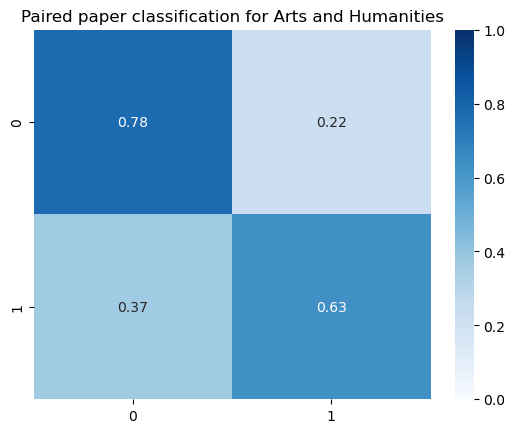

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Baseline task: 使用 Scopus_label 进行分类
print(f"\nBaseline task: Binary classification based on Scopus_label ({target_Scopus_label} V.S. others)")

# 拟合 TF-IDF（仅在训练数据上）
print("Fitting TF-IDF vectorizer...")
vectorizer = TfidfVectorizer(max_features=None, stop_words=stopwords.words('english'))
vectorizer.fit(train_data['OriginalVenue'])

print("Training and evaluating Random Forest classifier...")
predictions = train_and_evaluate_with_tfidf(vectorizer, train_data['OriginalVenue'], train_data['target_Scopus_label'], 
                              test_data['OriginalVenue'], test_data['target_Scopus_label'])

cm = confusion_matrix(test_data[f'target_Scopus_label'], predictions, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues', vmin=0, vmax=1)
plt.title(f"Paired paper classification for {target_Scopus_label}")
plt.show()


Baseline task: Binary classification based on cluster_label (Cluster No.:24 V.S. others)
Top words: ['linguistics', 'philosophy', 'language', 'history', 'psychology']
Training and evaluating Random Forest classifier...
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.81      0.69       149
           1       0.76      0.51      0.61       171

    accuracy                           0.65       320
   macro avg       0.68      0.66      0.65       320
weighted avg       0.68      0.65      0.65       320

Test accuracy: 0.653125


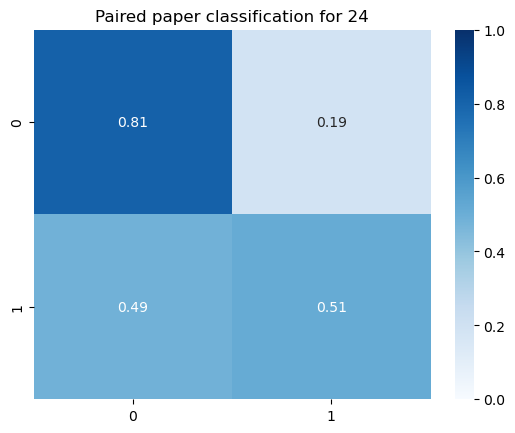

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 任务 2: 使用 cluster_label 进行分类 
print(f"\nBaseline task: Binary classification based on cluster_label (Cluster No.:{target_cluster_label} V.S. others)")
print("Top words:", top_words[target_cluster_label])

print("Training and evaluating Random Forest classifier...")
predictions = train_and_evaluate_with_tfidf(vectorizer, 
                                            train_data['OriginalVenue'], train_data[f'target_cluster_label'], 
                                            test_data['OriginalVenue'], test_data[f'target_cluster_label'])

cm = confusion_matrix(test_data[f'target_cluster_label'], predictions, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues', vmin=0, vmax=1)
plt.title(f"Paired paper classification for {target_cluster_label}")
plt.show()